https://desi.lbl.gov/trac/wiki/MilkyWayWG/PipelineOutputs

In [1]:
pwd

'/global/cfs/cdirs/desi/users/apcooper/projects/quicksv1'

In [2]:
import numpy as np
import glob
import os
import sys
import re
import subprocess
import fitsio
import healpy as hp
import warnings

from astropy.io import fits
from astropy.table import Table
import astropy.coordinates as coords
import astropy.units as u

import matplotlib.pyplot as pl
%matplotlib inline

In [3]:
from desitarget.sv1.sv1_targetmask import desi_mask, mws_mask, bgs_mask

In [4]:
import desi_retriever
import desi_retriever.andes

In [5]:
class MWSData():
    
    MWS_REDUX_DIR = '/global/cfs/cdirs/desi/science/mws/redux/'
    
    def __init__(self,redux='blanc',run=210112):
        """
        """
        self.redux_dirname = redux
        
        # Special cases
        if redux == 'sv_daily':
            self.redux = 'daily'
        else:
            self.redux = redux
        
        self.run = str(run)
        self.load_tables()   
        return
    
    def __repr__(self):
        return '{}-{}'.format(redux,coadd)
    
    def __getitem__(self,key):
        return self.fm[key]
    
    def rvtab_path(self):
        """
        """
        base = 'rvtab_spectra-{}.fits'.format(self.redux)
        return os.path.join(self.MWS_REDUX_DIR,self.redux_dirname,'rv_output',self.run,base)
    
    def load_tables(self):
        # Load tables
        self.fm = Table.read(self.mwtab_path(),'FIBERMAP')   
        try:
            self.rv = Table.read(self.mwtab_path(),'SPRVTAB ')    
        except KeyError:
            self.rv = Table.read(self.mwtab_path(),'RVTAB ')   

In [6]:
class MWSExposures(MWSData):
    """
    Single exposures.
    
    Example:
        d = MWSExposures(redux='sv_daily', run=210110)
    """
    def __repr__(self):
        return 'MWS: {}-exp-{} ({})'.format(self.redux, self.run, self.mwtab_path())
    
    def mwtab_path(self):
        """
        For single exposures there is no combined table, yet
        """
        return self.rvtab_path()
    
    def fetch_spec_for_targetid(self,targetid,iexp=0,with_model=True):
        """
        """
        i = np.flatnonzero(self['TARGETID'] == targetid)[iexp]
        
        tileid = self.fm['TILEID'][i]
        night = self.fm['NIGHT'][i]
        fiber = self.fm['FIBER'][i]
            
        D = desi_retriever.andes.fetcher.get_specs(tileid=tileid,
                                               night=night,
                                               fiber=fiber,
                                               targetid=targetid,
                                               coadd=False,
                                               dataset=self.redux)
        
        if with_model:
            Dmod = desi_retriever.andes.fetcher.get_rvspec_models(tileid=tileid,
                                                        night=night,
                                                        fiber=fiber,
                                                        targetid=targetid, 
                                                        run=self.run,
                                                        coadd=True,
                                                        dataset=self.redux_dirname)
                
        if with_model:
            return D, Dmod
        else:
            return D

In [7]:
class MWSCoadd(MWSData):
    """
    Coadds are by tile, either:
        - nightly
        - all
        - deep
    
    Not all tiles have all coadd types.
    
    Example:
         # Read blanc coadds for all exposures
         MWSCoadd(coadd='all') 
    """
    def __init__(self,redux='blanc',coadd='all'):
        assert(coadd is not None)
        self.coadd = coadd
        super().__init__(redux)
            
    def __repr__(self):
        return 'MWS: {}-{} ({})'.format(self.redux,self.coadd, self.mwtab_path())
  
    def mwtab_path(self):
        """
        For the coadds, there is a 'master' table.
        """
        base = 'mwtab_coadd-{}-{}.fits'.format(self.redux,self.coadd)
        return os.path.join(self.MWS_REDUX_DIR,self.redux,base)
    
    def fetch_spec_for_targetid(self,targetid,night=None,with_model=True):
        """
        """
        i = np.flatnonzero(self['TARGETID'] == targetid)
        
        tileid = self.fm['TILEID'][i]
        fiber = self.fm['FIBER'][i]
        
        if self.coadd == 'nights':
            assert(night is not None)
            
        D = desi_retriever.andes.fetcher.get_specs(tileid=tileid,
                                               night=night,
                                               fiber=fiber,
                                               targetid=targetid,
                                               coadd=True,
                                               dataset=self.redux)
        
        return D

In [112]:
def plot_targetid(d,targetid,iexp=0):
    """
    """
    pl.figure(figsize=(15,8))
    D, Dmod = d.fetch_spec_for_targetid(targetid,iexp=iexp, with_model=True)

    ispec = 0
    ax0 = pl.subplot(411,label='b')
    pl.plot(D[ispec]['b_wavelength'],D[ispec]['b_flux'],color='lightblue');

    ax1 = pl.subplot(412,label='r')
    pl.plot(D[ispec]['r_wavelength'],D[ispec]['r_flux'],color='lightgreen');

    ax2 = pl.subplot(413,label='z')
    pl.plot(D[ispec]['z_wavelength'],D[ispec]['z_flux'],color='red');

    ax3 = pl.subplot(414,label='all')
    pl.plot(D[ispec]['b_wavelength'],D[ispec]['b_flux'],color='k')
    pl.plot(D[ispec]['r_wavelength'],D[ispec]['r_flux'],color='k')
    pl.plot(D[ispec]['z_wavelength'],D[ispec]['z_flux'],color='k') 
    
    pl.sca(ax0);pl.plot(Dmod[ispec]['b_wavelength'],Dmod[ispec]['b_model'],color='blue');
    pl.sca(ax1);pl.plot(Dmod[ispec]['r_wavelength'],Dmod[ispec]['r_model'],color='g');
    pl.sca(ax2);pl.plot(Dmod[ispec]['z_wavelength'],Dmod[ispec]['z_model'],color='purple')
    
    for ax,band in zip([ax0,ax1,ax2,ax3],['b','r','z','r']):
        pl.sca(ax)
        fluxname = '{}_flux'.format(band)
        positive_flux = D[ispec][fluxname] > 0
        ymin = np.maximum(-10,np.min(D[ispec][fluxname]))
        ymax = 3*np.median(D[ispec][fluxname][positive_flux])
        pl.ylim(ymin,ymax)

    mag_g = 22.5-2.5*np.log10(d['FLUX_G'][i])
    mag_r = 22.5-2.5*np.log10(d['FLUX_R'][i])  
    
    return D,Dmod

In [8]:
d = MWSExposures(redux='sv_daily',run=210110)
d

MWS: daily-exp-210110 (/global/cfs/cdirs/desi/science/mws/redux/sv_daily/rv_output/210110/rvtab_spectra-daily.fits)

The RV table is in d.rv and the 'fibermap' in d.fm (the fibermap columns can also be accessed directly throuhg d[]). If you don't want to use those objects just load the corresponding rv and fibermap tables and substitute below.

In [9]:
# Summary of target types
Table(np.unique(d['SV1_MWS_TARGET'],return_counts=True),names=[None,'Counts'])

SV1_MWS_TARGET,Counts
int64,int64
0,524734
4,241
17,123481
21,155
33,139391
37,215
49152,10544
49156,89
81920,14656


In [246]:
def spec_ok(rv,success='SUCCESS'):
    return (rv[success]) & (rv['SN_B'] > 2) & (rv['SN_R'] > 2) & (rv['SN_Z'] > 2)  & (rv['RVS_WARN'] == 0)

def mws_samples(d):
    """
    """
    pm = np.sqrt(d['PMRA']**2 + d['PMDEC']**2)

    gmag = 22.5 - 2.5 * np.log10(d['FLUX_G'].clip(1e-7))
    rmag = 22.5 - 2.5 * np.log10(d['FLUX_R'].clip(1e-7))
    zmag = 22.5 - 2.5 * np.log10(d['FLUX_Z'].clip(1e-7))

    gmr = gmag - rmag
    rmz = rmag - zmag
    
    is_mws_red = (rmag < 19) & (pm < 7.0) & (np.isfinite(pm)) & (gmr > 0.7)
    is_mws_blue = (rmag < 19) & (gmr < 0.7)
    is_mws_broad = (rmag < 19) & ((pm >= 7.0) | (~np.isfinite(pm))) & (gmr > 0.7)
    
    return is_mws_red,is_mws_blue,is_mws_broad

In [247]:
def plot_compare_mws_samples(prop,d,bins,decorate=None,density=False,success='SUCCESS',sel=None):
    """
    """
    is_mws_red,is_mws_blue,is_mws_broad = mws_samples(d)
    
    mws_sv_target = (d['SV1_MWS_TARGET'] > 0) & (d['SV1_MWS_TARGET'] != 999999)

    specok = spec_ok(d.rv,success=success) 
    
    if sel is not None:
        specok &= sel

    h_red,_ = np.histogram(prop[is_mws_red & specok],bins=bins,density=density)
    h_blue,_ = np.histogram(prop[is_mws_blue & specok],bins=bins,density=density)
    h_broad,_ = np.histogram(prop[is_mws_broad & specok],bins=bins,density=density)

    h_red_mw,_ = np.histogram(prop[is_mws_red & specok & mws_sv_target],bins=bins,density=density)
    h_blue_mw,_ = np.histogram(prop[is_mws_blue & specok & mws_sv_target],bins=bins,density=density)
    h_broad_mw,_ = np.histogram(prop[is_mws_broad & specok & mws_sv_target],bins=bins,density=density)
    
    pl.figure(figsize=(12,6))

    pl.subplot(121)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pl.plot(bins[:-1],np.log10(h_red),drawstyle='steps-post',c='r',label='RED (all)')
        pl.plot(bins[:-1],np.log10(h_blue),drawstyle='steps-post',c='b',label='BLUE (all)')
        pl.plot(bins[:-1],np.log10(h_broad),drawstyle='steps-post',c='g',label='BROAD (all)')

    if decorate is not None:
        decorate()
    pl.title('All r < 19')
    
    pl.subplot(122)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pl.plot(bins[:-1],np.log10(h_red_mw),drawstyle='steps-post',c='r',label='SV1 MWS targets')
        pl.plot(bins[:-1],np.log10(h_blue_mw),drawstyle='steps-post',c='b')
        pl.plot(bins[:-1],np.log10(h_broad_mw),drawstyle='steps-post',c='g')

    if decorate is not None:
        decorate()
    pl.title('MWS Targets only')

    return

In [248]:
# MWS Selection criteria
# (missing parallax: parallax error column doesn't get propagated through to spec files)

pm = np.sqrt(d['PMRA']**2 + d['PMDEC']**2)

gmag = 22.5 - 2.5 * np.log10(d['FLUX_G'].clip(1e-7))
rmag = 22.5 - 2.5 * np.log10(d['FLUX_R'].clip(1e-7))
zmag = 22.5 - 2.5 * np.log10(d['FLUX_Z'].clip(1e-7))

gmr = gmag - rmag
rmz = rmag - zmag

Everything...

<ipython-input-249-b07e69b351b4>:1: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr,np.log10(np.abs(pm)),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)


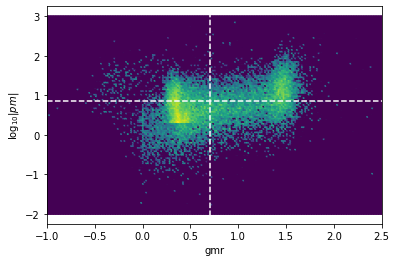

In [249]:
pl.hexbin(gmr,np.log10(np.abs(pm)),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

Bright targets

<ipython-input-250-0ac59b9fbf5a>:2: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright],np.log10(np.abs(pm[bright])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)


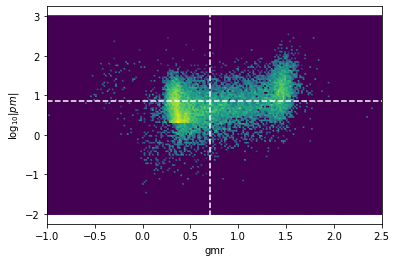

In [250]:
bright = rmag < 19
pl.hexbin(gmr[bright],np.log10(np.abs(pm[bright])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

In [251]:
mws_sv_target = (d['SV1_MWS_TARGET'] > 0) & (d['SV1_MWS_TARGET'] != 999999)

Bright targets with usable spectra

In [252]:
bright = rmag < 19
specok = spec_ok(d.rv)
print(specok.sum(),len(d.rv), specok.sum()/len(d.rv))
print((bright & specok).sum(),len(d.rv), (bright & specok).sum()/len(d.rv))

265212 827395 0.3205385577626164
244204 827395 0.29514802482490227


<ipython-input-253-a2dd8a284c74>:1: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)


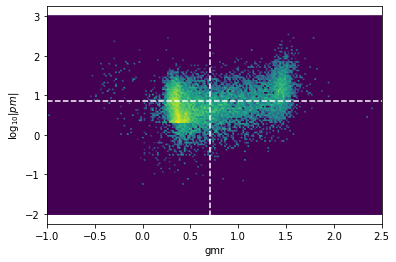

In [253]:
pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

<ipython-input-254-3a28cf69403c>:2: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),


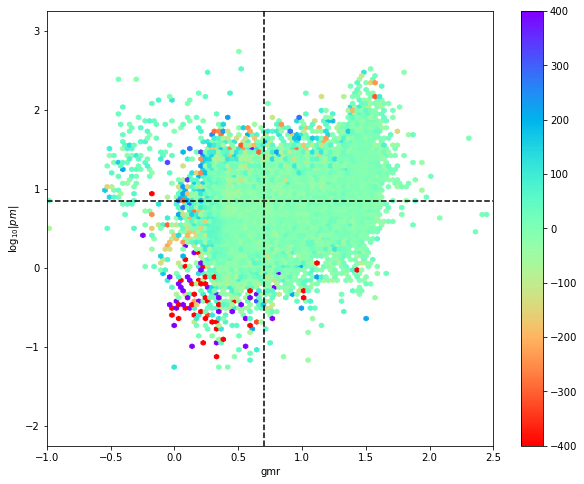

In [254]:
pl.figure(figsize=(10,8))
pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),
          C=d.rv['VRAD'][bright & specok],vmax=400,vmin=-400,
          reduce_C_function=np.median,cmap='rainbow_r',
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='k',ls='--')
pl.axhline(np.log10(7),c='k',ls='--')
pl.colorbar()

<ipython-input-255-edcc90969437>:2: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),


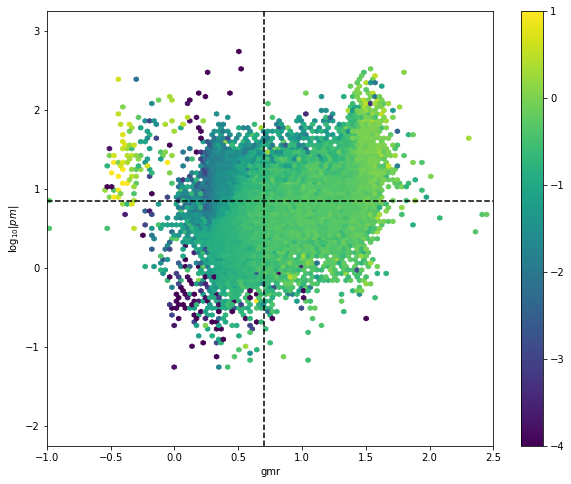

In [255]:
pl.figure(figsize=(10,8))
pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),
          C=d.rv['FEH'][bright & specok],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='k',ls='--')
pl.axhline(np.log10(7),c='k',ls='--')
pl.colorbar()

<ipython-input-256-8a10a3ae018e>:2: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),


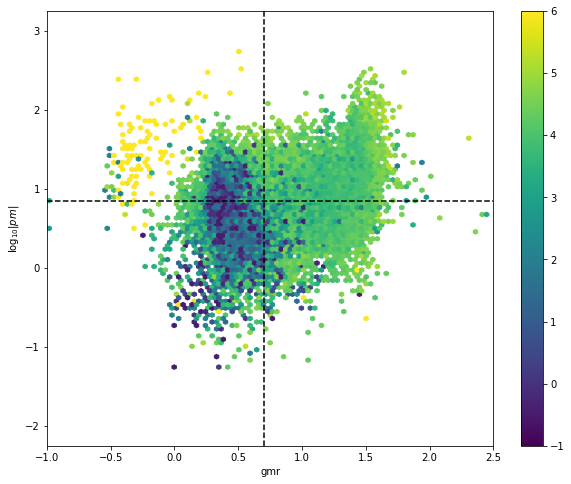

In [256]:
pl.figure(figsize=(10,8))
pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),
          C=d.rv['LOGG'][bright & specok],vmax=6,vmin=-1,
          reduce_C_function=np.min,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='k',ls='--')
pl.axhline(np.log10(7),c='k',ls='--')
pl.colorbar()

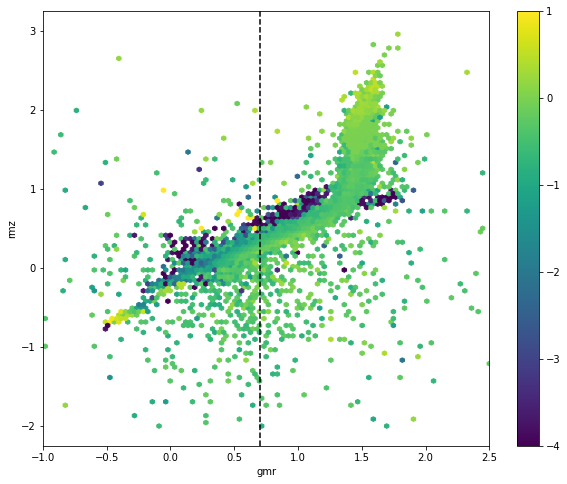

In [257]:
pl.figure(figsize=(10,8))
pl.hexbin(gmr[bright & specok],rmz[bright & specok],
          C=d.rv['FEH'][bright & specok],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()

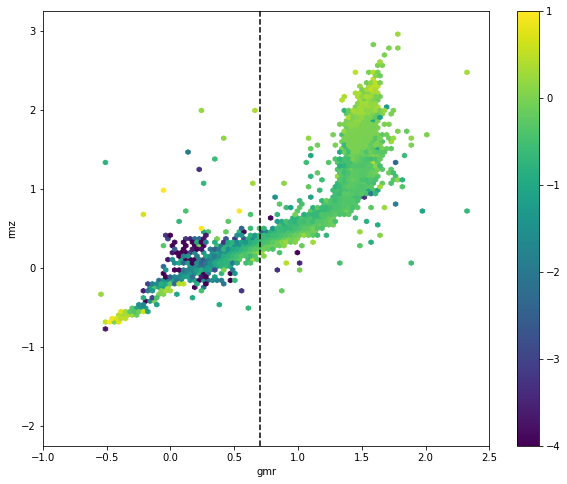

In [258]:
pl.figure(figsize=(10,8))
pl.hexbin(gmr[bright & specok & mws_sv_target],rmz[bright & specok & mws_sv_target],
          C=d.rv['FEH'][bright & specok & mws_sv_target],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()


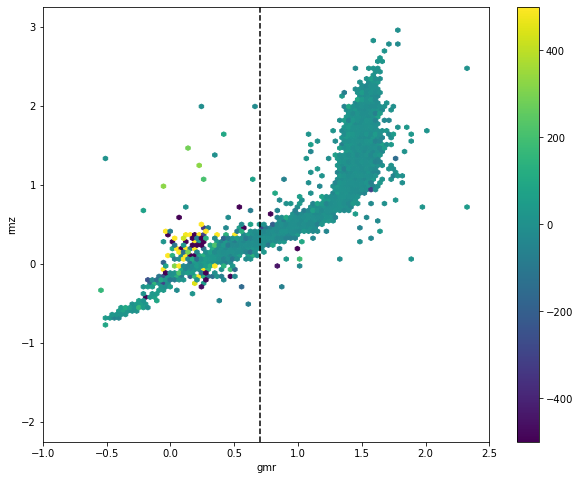

In [259]:
pl.figure(figsize=(10,8))
pl.hexbin(gmr[bright & specok & mws_sv_target],rmz[bright & specok & mws_sv_target],
          C=d.rv['VRAD'][bright & specok & mws_sv_target],vmax=500,vmin=-500,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()

Text(0.5, 0, 'g-r')

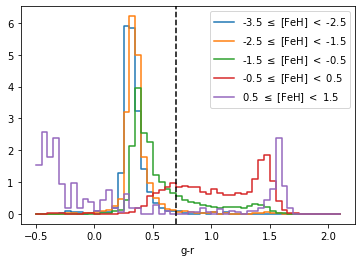

In [260]:
gmr_bins = np.arange(-0.5,2.2,0.05)
feh_bins = np.arange(-3.5,2.5,1)

for feh_l,feh_h in zip(feh_bins[:-1],feh_bins[1:]):
    sel = (feh_l <= d.rv['FEH']) &  (d.rv['FEH'] < feh_h)
    sel &= bright & specok & mws_sv_target
    h,b = np.histogram(gmr[sel],bins=gmr_bins,density=True)
    pl.plot(b[:-1],h,drawstyle='steps-post',label='{:3.1f} $\leq$ [FeH] $<$ {:3.1f}'.format(feh_l,feh_h))
pl.legend()
pl.axvline(0.7,c='k',ls='--')
pl.xlabel('g-r')

In [261]:
is_mws_red,is_mws_blue,is_mws_broad = mws_samples(d)

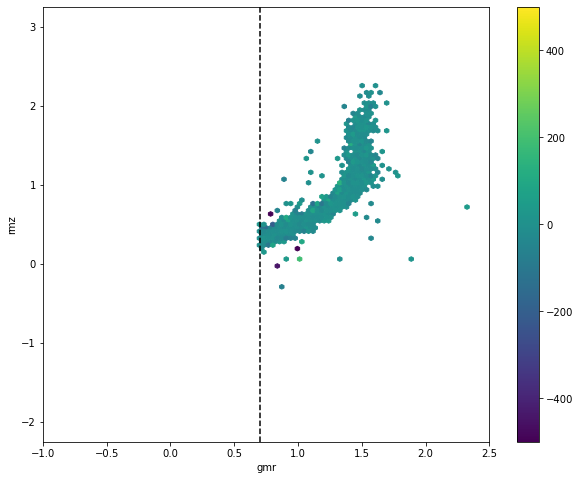

In [262]:
pl.figure(figsize=(10,8))
sel = bright & specok & mws_sv_target & is_mws_red
pl.hexbin(gmr[sel],rmz[sel],
          C=d.rv['VRAD'][sel],vmax=500,vmin=-500,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()

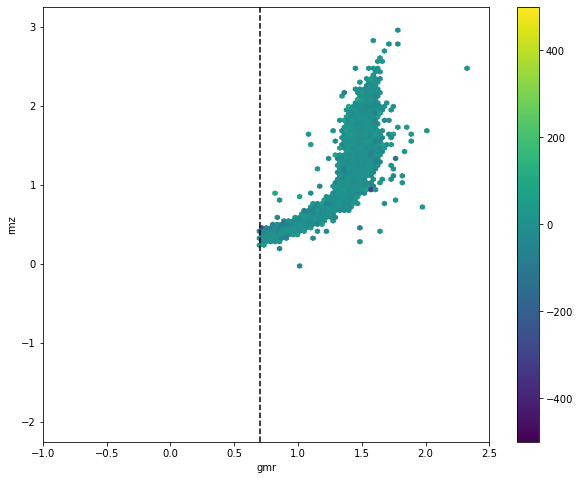

In [264]:
pl.figure(figsize=(10,8))
sel = bright & specok & mws_sv_target & is_mws_broad
pl.hexbin(gmr[sel],rmz[sel],
          C=d.rv['VRAD'][sel],vmax=500,vmin=-500,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()

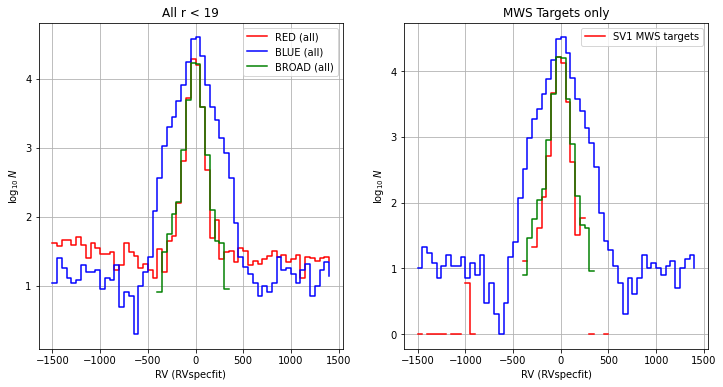

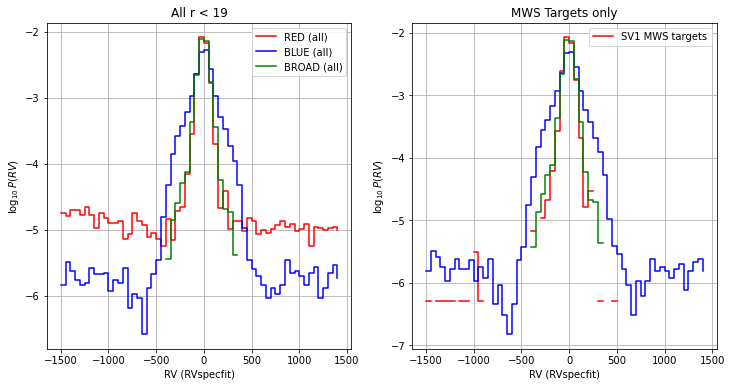

In [267]:
# Top: absolute; bottom: fraction

def decorate():
    pl.grid()
    pl.xlabel('RV (RVspecfit)')
    pl.ylabel('$\log_{10}\,N$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['VRAD'],d,np.arange(-1500,1500,50),decorate=decorate)

def decorate():
    pl.grid()
    pl.xlabel('RV (RVspecfit)')
    pl.ylabel('$\log_{10}\,P(RV)$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['VRAD'],d,np.arange(-1500,1500,50),decorate=decorate,density=True)

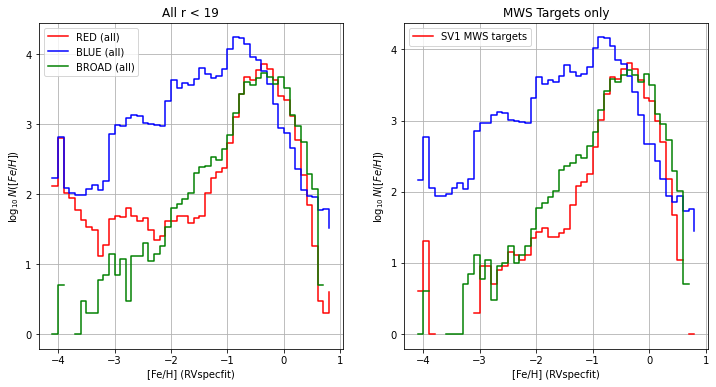

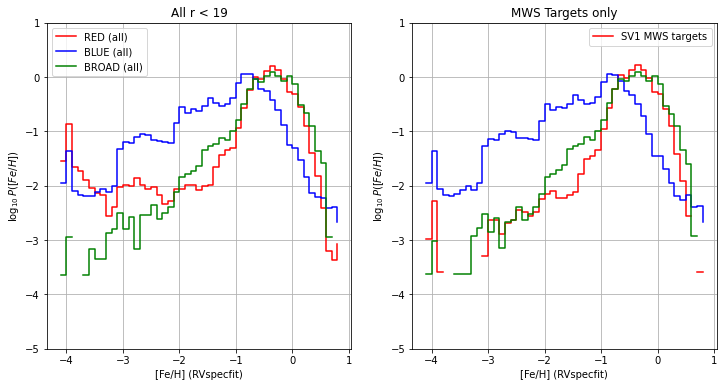

In [268]:
def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit)')
    pl.ylabel('$\log_{10}\,N([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['FEH'],d,np.arange(-5,1,0.1),decorate=decorate,density=False)

def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit)')
    pl.ylabel('$\log_{10}\,P([Fe/H])$')
    pl.legend()
    pl.ylim(-5,1)
    
plot_compare_mws_samples(d.rv['FEH'],d,np.arange(-5,1,0.1),decorate=decorate,density=True)

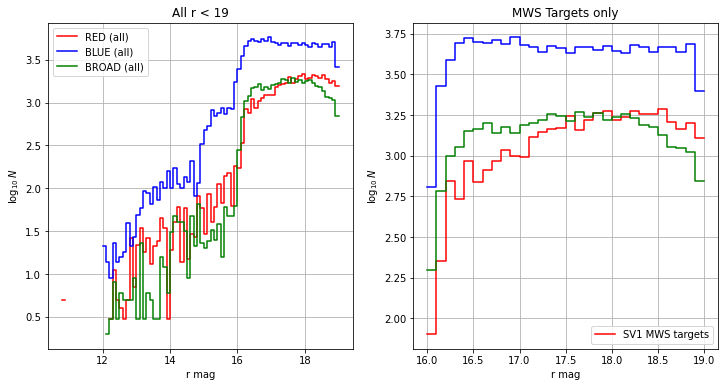

In [272]:
# r mag,absolute

def decorate():
    pl.grid()
    pl.xlabel('r mag')
    pl.ylabel('$\log_{10}\,N$')
    pl.legend()
    
plot_compare_mws_samples(rmag,d,np.arange(10,22,0.1),decorate=decorate)

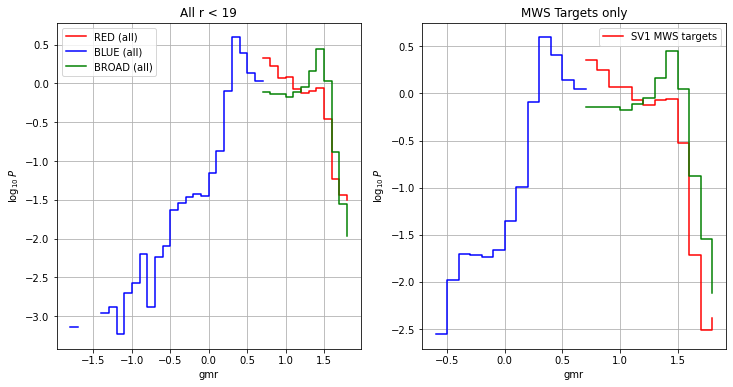

In [274]:
# g-r, probabilty

def decorate():
    pl.grid()
    pl.xlabel('gmr')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(gmr,d,np.arange(-2,2,0.1),decorate=decorate,density=True)

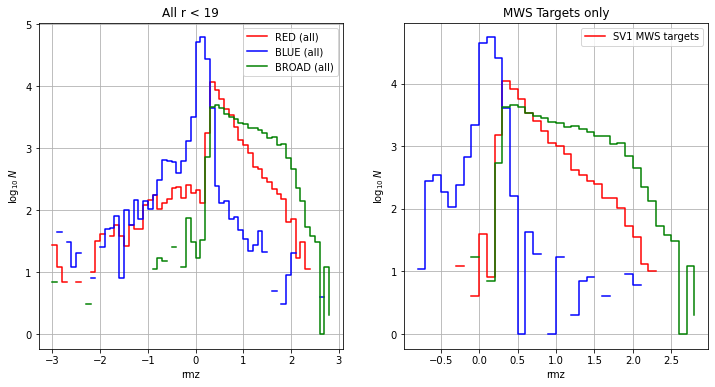

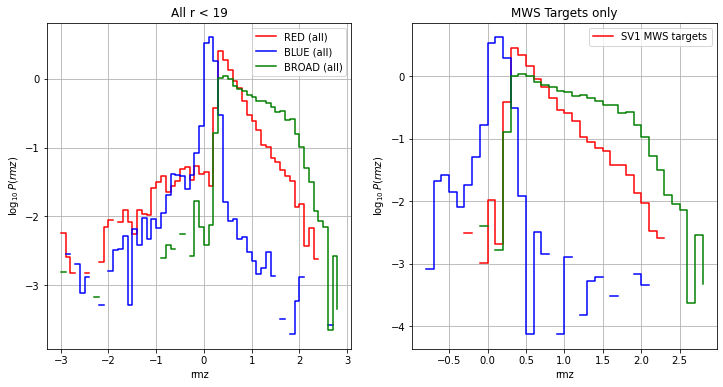

In [275]:
def decorate():
    pl.grid()
    pl.xlabel('rmz')
    pl.ylabel('$\log_{10}\,N$')
    pl.legend()
    
plot_compare_mws_samples(rmz,d,np.arange(-3,3,0.1),decorate=decorate,density=False)

def decorate():
    pl.grid()
    pl.xlabel('rmz')
    pl.ylabel('$\log_{10}\,P(rmz)$')
    pl.legend()
    
plot_compare_mws_samples(rmz,d,np.arange(-3,3,0.1),decorate=decorate,density=True)

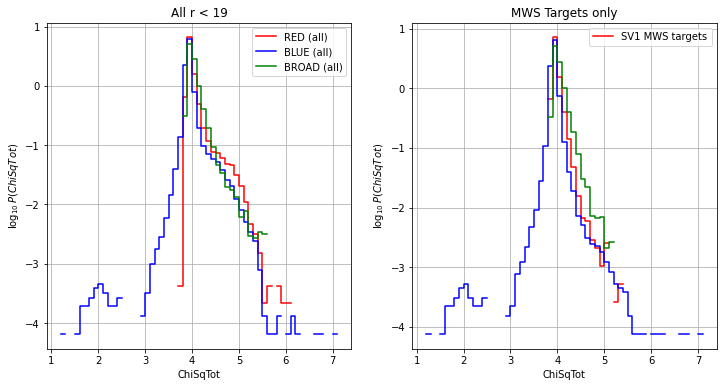

In [276]:
def decorate():
    pl.grid()
    pl.xlabel('ChiSqTot')
    pl.ylabel('$\log_{10}\,P(ChiSqTot)$')
    pl.legend()
plot_compare_mws_samples(np.log10(d.rv['CHISQ_TOT']),d,np.arange(1,10,0.1),decorate=decorate,density=True)

In [277]:
c = MWSCoadd(redux='blanc')
c

MWS: blanc-all (/global/cfs/cdirs/desi/science/mws/redux/blanc/mwtab_coadd-blanc-all.fits)

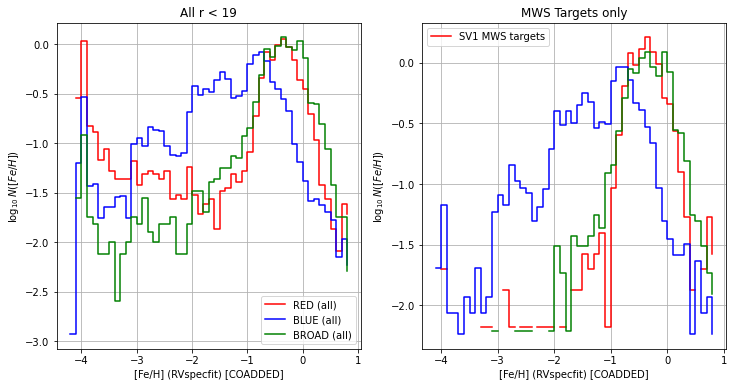

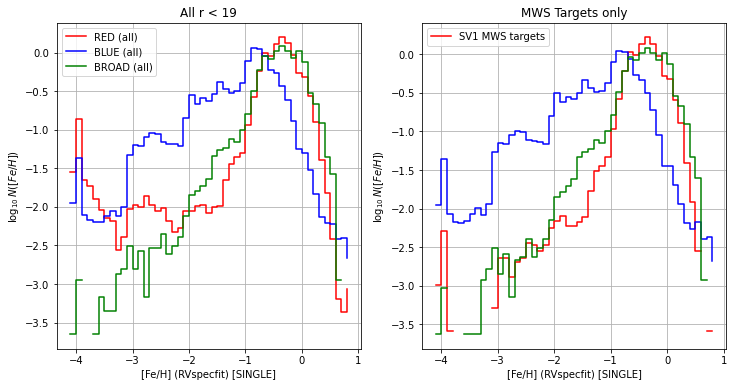

In [278]:
def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit) [COADDED]')
    pl.ylabel('$\log_{10}\,N([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(c.rv['FEH_RV'],c,np.arange(-5,1,0.1),
                         decorate=decorate,density=True,success='SUCCESS_RV')

def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit) [SINGLE]')
    pl.ylabel('$\log_{10}\,N([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['FEH'],d,np.arange(-5,1,0.1),
                         decorate=decorate,density=True)

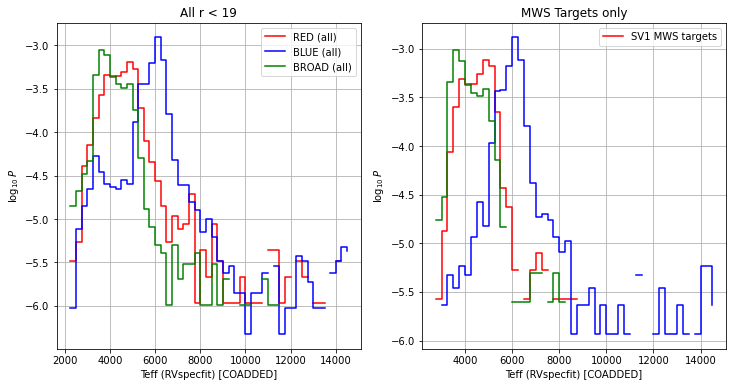

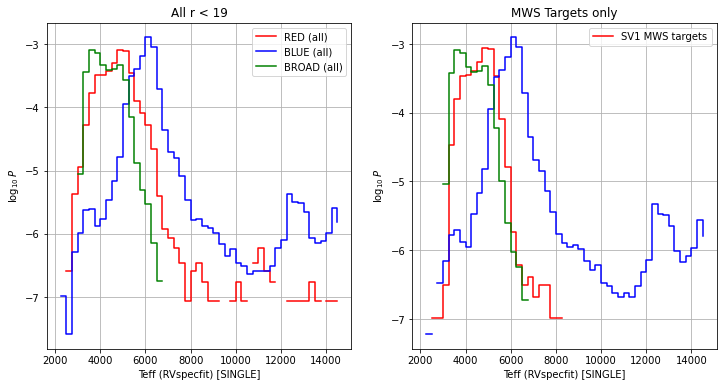

In [279]:
def decorate():
    pl.grid()
    pl.xlabel('Teff (RVspecfit) [COADDED]')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(c.rv['TEFF_RV'],c,np.arange(0,15000,250),decorate=decorate,density=True,success='SUCCESS_RV')

def decorate():
    pl.grid()
    pl.xlabel('Teff (RVspecfit) [SINGLE]')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['TEFF'],d,np.arange(0,15000,250),decorate=decorate,density=True)

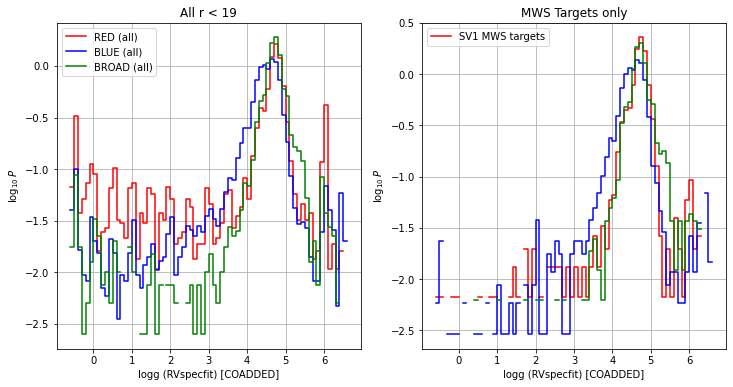

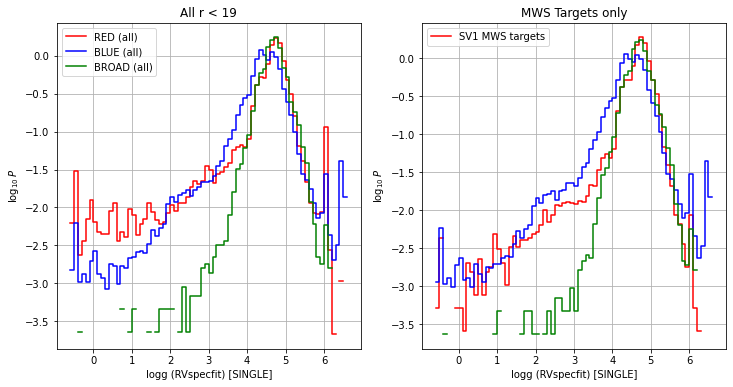

In [280]:
def decorate():
    pl.grid()
    pl.xlabel('logg (RVspecfit) [COADDED]')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(c.rv['LOGG_RV'],c,np.arange(-1,7,0.1),decorate=decorate,density=True,success='SUCCESS_RV')

def decorate():
    pl.grid()
    pl.xlabel('logg (RVspecfit) [SINGLE]')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['LOGG'],d,np.arange(-1,7,0.1),decorate=decorate,density=True)

(8.0, -1.0)

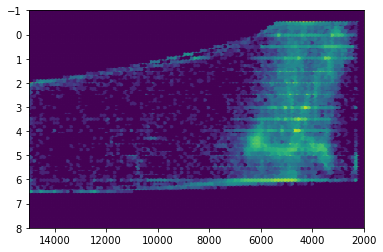

In [281]:
pl.hexbin(c.rv['TEFF_RV'],c.rv['LOGG_RV'],extent=(2000,15000,-1,8),bins='log')
pl.xlim(15000,2000)
pl.ylim(8,-1)

(8.0, -1.0)

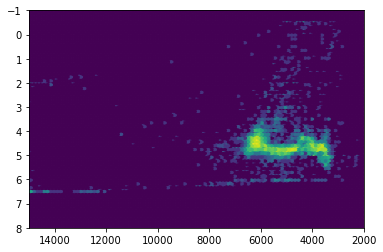

In [282]:
pl.hexbin(c.rv['TEFF_RV'][coadd_is_mws_target],c.rv['LOGG_RV'][coadd_is_mws_target],extent=(2000,15000,-1,8),bins='log')
pl.xlim(15000,2000)
pl.ylim(8,-1)

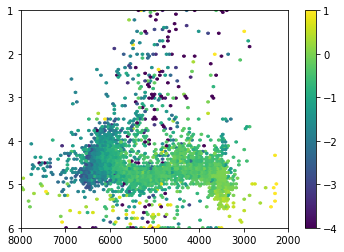

In [283]:
pl.hexbin(c.rv['TEFF_RV'][coadd_is_mws_target],c.rv['LOGG_RV'][coadd_is_mws_target],
          C=c.rv['FEH_RV'][coadd_is_mws_target],reduce_C_function=np.median,
          extent=(2000,8000,1,6),gridsize=100)
pl.xlim(8000,2000)
pl.ylim(6,1)
pl.colorbar()

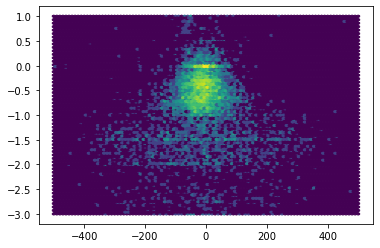

In [284]:
pl.hexbin(c.rv['VRAD'][coadd_is_mws_target],c.rv['FEH_RV'][coadd_is_mws_target],bins='log',extent=(-500,500,-3,1))

https://desi.lbl.gov/trac/wiki/SurveyValidation/SV1

https://desi.lbl.gov/trac/wiki/DESIOperations/ObservingPlans/OpsPlan20210101

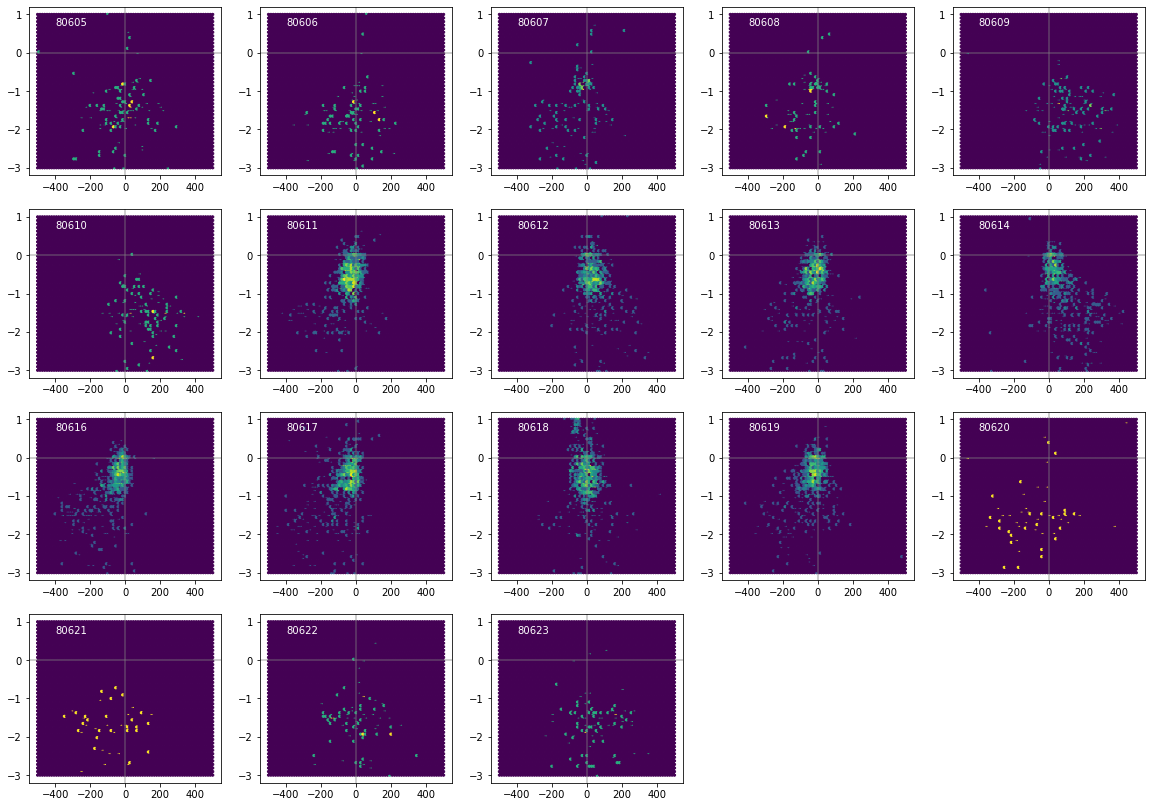

In [285]:
tileids = np.unique(c.fm['TILEID'][coadd_is_mws_target])
nplots = len(tileids)
nrow = int(np.ceil(np.sqrt(nplots)))

f = pl.figure(figsize=(20,18))

from matplotlib import gridspec
grid = gridspec.GridSpec(nrow,nrow)

for i,tileid in enumerate(tileids):
    f.add_subplot(grid[i])
    sel = (c.fm['TILEID'] == tileid) & coadd_is_mws_target
    pl.hexbin(c.rv['VRAD'][sel],
              c.rv['FEH_RV'][sel],
              gridsize=75,
              bins='log',extent=(-500,500,-3,1))
    pl.text(-400,0.7,tileid,fontsize=10,c='w')
    pl.axvline(0,c='grey',alpha=0.5)
    pl.axhline(0,c='grey',alpha=0.5)

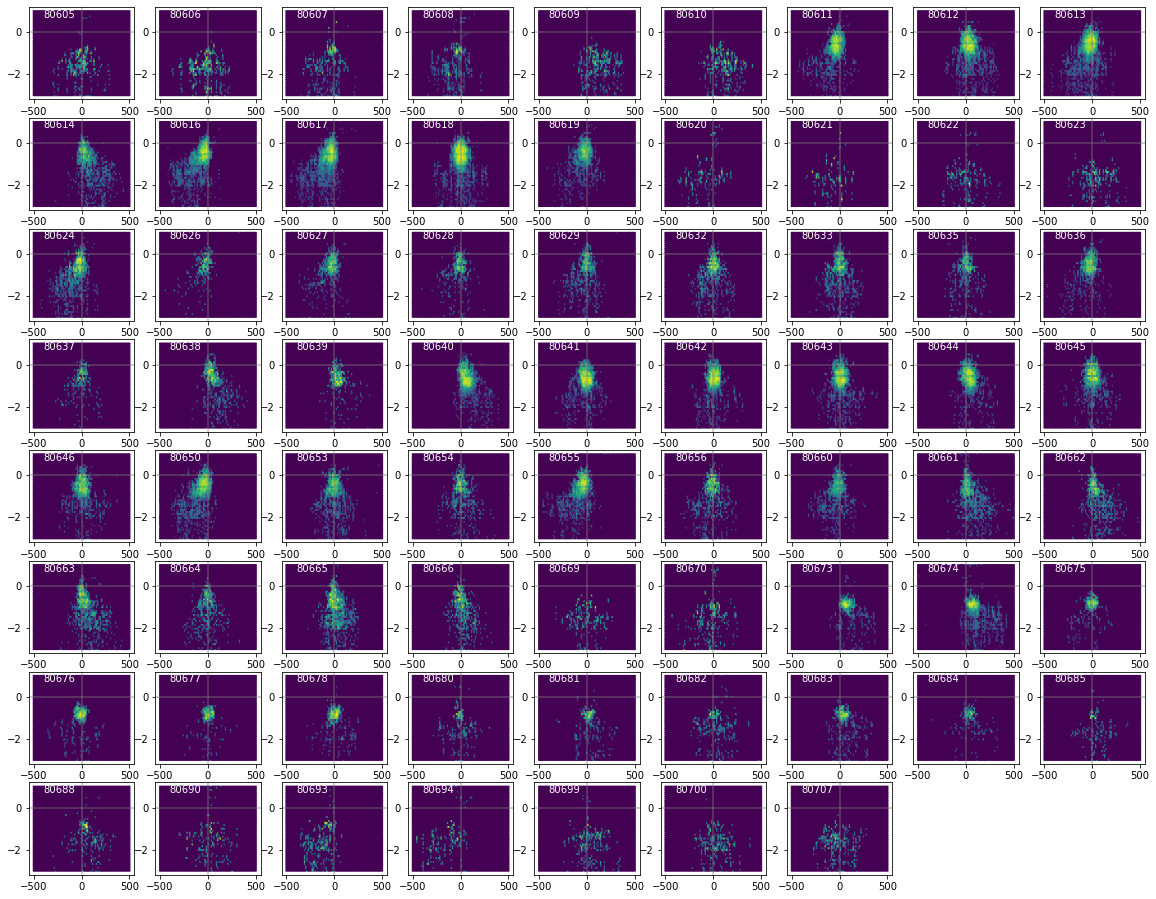

In [286]:
tileids = np.unique(d.fm['TILEID'][mws_sv_target & bright])
nplots = len(tileids)
nrow = int(np.ceil(np.sqrt(nplots)))

f = pl.figure(figsize=(20,18))

grid = gridspec.GridSpec(nrow,nrow)

for i,tileid in enumerate(tileids):
    f.add_subplot(grid[i])
    sel = (d.fm['TILEID'] == tileid) & mws_sv_target & bright & specok
    pl.hexbin(d.rv['VRAD'][sel],
              d.rv['FEH'][sel],
              gridsize=75,
              bins='log',extent=(-500,500,-3,1))
    pl.text(-400,0.7,tileid,fontsize=10,c='w')
    pl.axvline(0,c='grey',alpha=0.5)
    pl.axhline(0,c='grey',alpha=0.5)

In [287]:
n2419 = d['TILEID'] == 80618
c_n2419 = c['TILEID'] == 80618

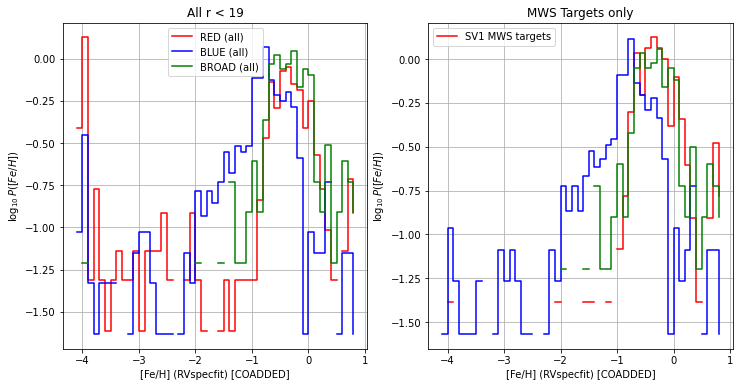

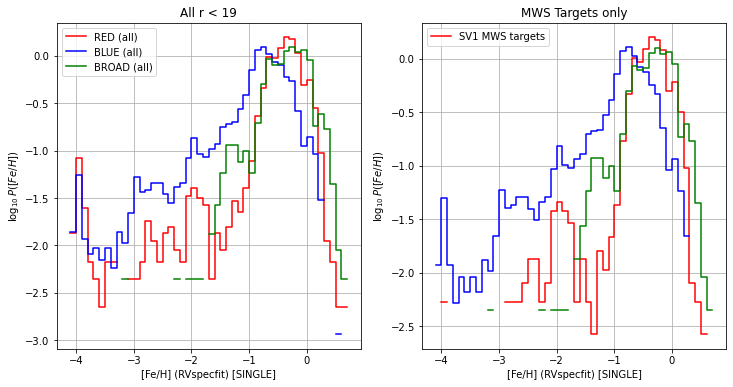

In [288]:
def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit) [COADDED]')
    pl.ylabel('$\log_{10}\,P([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(c.rv['FEH_RV'],c,np.arange(-5,1,0.1),decorate=decorate,density=True,success='SUCCESS_RV',sel=c_n2419)

def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit) [SINGLE]')
    pl.ylabel('$\log_{10}\,P([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['FEH'],d,np.arange(-5,1,0.1),decorate=decorate,density=True,sel=n2419)

(19.5, 16.0)

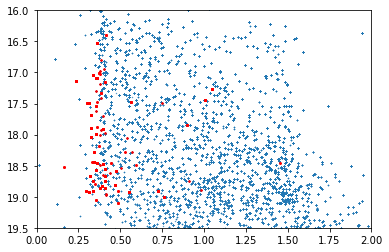

In [289]:
sel = n2419
lowz = n2419 & (d.rv['FEH'] < -2) & mws_sv_target & specok
pl.scatter(gmr[sel],rmag[sel],s=0.5,marker='.')
pl.scatter(gmr[lowz],rmag[lowz],s=10,marker='.',zorder=10,c='r')
pl.xlim(0,2)
pl.ylim(19.5,16)

(111.96393687072678, 116.44786821135334, 36.702204186764, 40.24271873704268)

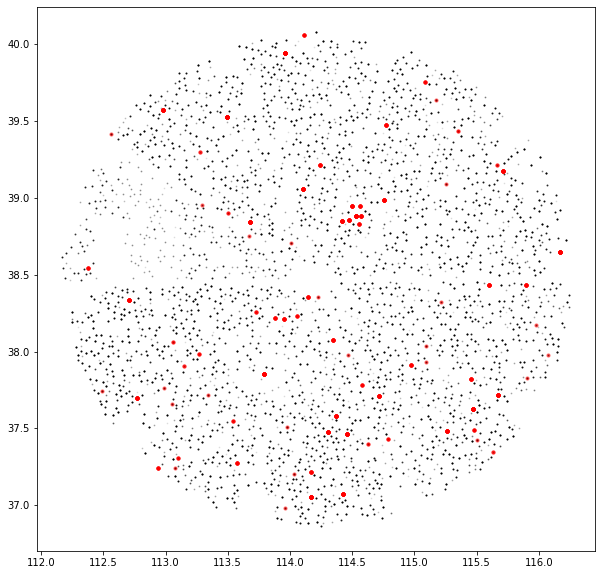

In [290]:
pl.figure(figsize=(10,10))
pl.scatter(d['TARGET_RA'][sel],d['TARGET_DEC'][sel],s=0.5,marker='o',alpha=0.1,c='k')
pl.scatter(d['TARGET_RA'][lowz],d['TARGET_DEC'][lowz],s=10,marker='o',zorder=10,alpha=0.5,c='r')
pl.axis('auto')

In [291]:
import matplotlib.gridspec as gridspec

In [292]:
coadd_is_mws_target = (c['SV1_MWS_TARGET'] > 0) & (c['SV1_MWS_TARGET'] != 999999)
sel = coadd_is_mws_target
Table(np.unique(c['TILEID'][sel],return_counts=True))

TILEID,col1
int32,int64
80605,169
80606,109
80607,178
80608,97
80609,172
80610,115
80611,776
80612,746
80613,783


In [293]:
Table(np.unique(d['TILEID'],return_counts=True))

TILEID,col1
int32,int64
80254,8173
80605,9151
80606,2021
80607,13640
80608,3650
80609,11170
80610,2223
80611,21348
80612,33181


In [294]:
radec = coords.SkyCoord(d['TARGET_RA'],d['TARGET_DEC'],frame='icrs',unit='deg')

In [295]:
gal = radec.transform_to('galactic')

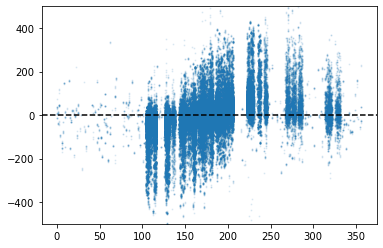

In [296]:
sel = mws_sv_target & bright & specok & (d.rv['RVS_WARN'] == 0)
pl.scatter(gal.l[sel],d.rv['VRAD'][sel],s=1,alpha=0.1)
pl.ylim(-500,500)
pl.axhline(0,c='k',ls='--')

In [297]:
(is_mws_red & specok).sum()

46804

In [298]:
(is_mws_broad & specok).sum()

44455

In [219]:
d['PARALLAX','PMRA','PMDEC']

PARALLAX,PMRA,PMDEC
float32,float32,float32
0.2421939,1.1432372,-3.8170185
0.0,0.0,0.0
0.12624942,-0.3449254,-2.3723445
0.0,0.0,0.0
0.0,0.0,0.0
0.7870298,-0.43930814,-0.11540886
-0.24068613,-2.0664961,-0.9580405
0.11183568,-0.46135348,-2.931927
0.03469967,6.7614417,-13.687192


In [224]:
c['PARALLAX','PMRA','GAIA_ASTROMETRIC_PARAMS_SOLVED']

PARALLAX,PMRA,GAIA_ASTROMETRIC_PARAMS_SOLVED
float32,float32,bool
1.3864727,-0.7723985,True
1.0046731,-20.526825,True
0.5868535,-11.648711,True
0.22243217,-10.532552,True
0.3468994,-11.568564,True
0.6195192,-15.4206085,True
0.75662374,-13.848109,True
1.7476856,30.44077,True
2.0049965,1.9385488,True
